# Execute the code below

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [5]:
link_main = "https://raw.githubusercontent.com/murpi/wilddata/master/quests/weather_main_2018.csv"
link_opinion = "https://raw.githubusercontent.com/murpi/wilddata/master/quests/weather_opinion_2018.csv"
df_main = pd.read_csv(link_main)
df_opinion = pd.read_csv(link_opinion)
print(df_main.head())
print(df_opinion.head())

         DATE  MAX_TEMPERATURE_C  ...  DEWPOINT_MAX_C  WINDTEMP_MAX_C
0  2018-01-01                 12  ...               8               7
1  2018-01-02                 13  ...              12               6
2  2018-01-03                 15  ...              13               7
3  2018-01-04                 14  ...              12              10
4  2018-01-05                 12  ...              10               7

[5 rows x 15 columns]
         date  WEATHER_CODE_EVENING  TOTAL_SNOW_MM  UV_INDEX  SUNHOUR OPINION
0  2018-01-01                   113              0         3      5.1     bad
1  2018-03-12                   119              0         2      8.8     bad
2  2018-03-09                   116              0         3     10.2     bad
3  2018-10-07                   122              0         1      5.6     bad
4  2018-06-18                   119              0         1     12.9     bad


# Classification challenge

Your goal are :
- to merge both 2018 DataFrames
- to train-test split the new 2018 DataFrame
- to train 3 differents Machine Learning algorithms (KNN, logistic regression and decision tree) with "opinion" as target
- to try different parameters
- to find the best accuracy score (on the test set of course)
- to fill the missing values in the "opinion" columns whith your best model
- to explain what is the "rules" used by your model to predict the opinion.

You can help yourself with charts if you want.

## 1. Merge

In [60]:
df2018 = df_main.merge(df_opinion, left_on = 'DATE', right_on='date', how='left')
df2018.drop('date', axis = 1, inplace=True)

df2018.head()


,DATE,MAX_TEMPERATURE_C,MIN_TEMPERATURE_C,WINDSPEED_MAX_KMH,TEMPERATURE_MORNING_C,TEMPERATURE_NOON_C,TEMPERATURE_EVENING_C,PRECIP_TOTAL_DAY_MM,HUMIDITY_MAX_PERCENT,VISIBILITY_AVG_KM,PRESSURE_MAX_MB,CLOUDCOVER_AVG_PERCENT,HEATINDEX_MAX_C,DEWPOINT_MAX_C,WINDTEMP_MAX_C,WEATHER_CODE_EVENING,TOTAL_SNOW_MM,UV_INDEX,SUNHOUR,OPINION
0,2018-01-01,12,8,61,9,11,8,8.9,79,9.500,1018,41.750,12,8,7,113.0,0.0,3.0,5.1,bad
1,2018-01-02,13,6,26,8,12,13,0.6,96,9.000,1020,87.875,13,12,6,122.0,0.0,3.0,3.3,bad
2,2018-01-03,15,10,40,11,12,10,5.5,82,8.500,1017,91.500,15,13,7,122.0,0.0,3.0,3.3,bad
3,2018-01-04,14,11,45,14,14,11,0.0,89,10.000,1011,90.125,14,12,10,116.0,0.0,3.0,3.3,bad
4,2018-01-05,12,7,21,10,11,8,1.5,85,9.875,1005,62.375,12,10,7,116.0,0.0,3.0,6.9,bad


## 2. Train test split

In [61]:
# séparer le DF en 2, un avec les valeurs manquantes et l'autre sans
df2018_clean = df2018[df2018['SUNHOUR'].notna()]
print("df2018_clean shape:", df2018_clean.shape)

df2018_nan =df2018[df2018['SUNHOUR'].isna()]
print("df2018_nan shape:", df2018_nan.shape)

print(df2018_clean.isna().sum())

df2018_clean shape: (341, 20)
df2018_nan shape: (24, 20)
DATE                      0
MAX_TEMPERATURE_C         0
MIN_TEMPERATURE_C         0
WINDSPEED_MAX_KMH         0
TEMPERATURE_MORNING_C     0
TEMPERATURE_NOON_C        0
TEMPERATURE_EVENING_C     0
PRECIP_TOTAL_DAY_MM       0
HUMIDITY_MAX_PERCENT      0
VISIBILITY_AVG_KM         0
PRESSURE_MAX_MB           0
CLOUDCOVER_AVG_PERCENT    0
HEATINDEX_MAX_C           0
DEWPOINT_MAX_C            0
WINDTEMP_MAX_C            0
WEATHER_CODE_EVENING      0
TOTAL_SNOW_MM             0
UV_INDEX                  0
SUNHOUR                   0
OPINION                   0
dtype: int64


In [62]:
# recherche de corrélations

# factoriser la colonne Opinion
# bad = 0, very bad = 1  , not good not bad = 3, good = 4 , very good = 2
df_fact = df2018_clean.copy()
df_fact['OPINION'] = df_fact['OPINION'].factorize()[0]

df_fact.head()

,DATE,MAX_TEMPERATURE_C,MIN_TEMPERATURE_C,WINDSPEED_MAX_KMH,TEMPERATURE_MORNING_C,TEMPERATURE_NOON_C,TEMPERATURE_EVENING_C,PRECIP_TOTAL_DAY_MM,HUMIDITY_MAX_PERCENT,VISIBILITY_AVG_KM,PRESSURE_MAX_MB,CLOUDCOVER_AVG_PERCENT,HEATINDEX_MAX_C,DEWPOINT_MAX_C,WINDTEMP_MAX_C,WEATHER_CODE_EVENING,TOTAL_SNOW_MM,UV_INDEX,SUNHOUR,OPINION
0,2018-01-01,12,8,61,9,11,8,8.9,79,9.500,1018,41.750,12,8,7,113.0,0.0,3.0,5.1,0
1,2018-01-02,13,6,26,8,12,13,0.6,96,9.000,1020,87.875,13,12,6,122.0,0.0,3.0,3.3,0
2,2018-01-03,15,10,40,11,12,10,5.5,82,8.500,1017,91.500,15,13,7,122.0,0.0,3.0,3.3,0
3,2018-01-04,14,11,45,14,14,11,0.0,89,10.000,1011,90.125,14,12,10,116.0,0.0,3.0,3.3,0
4,2018-01-05,12,7,21,10,11,8,1.5,85,9.875,1005,62.375,12,10,7,116.0,0.0,3.0,6.9,0


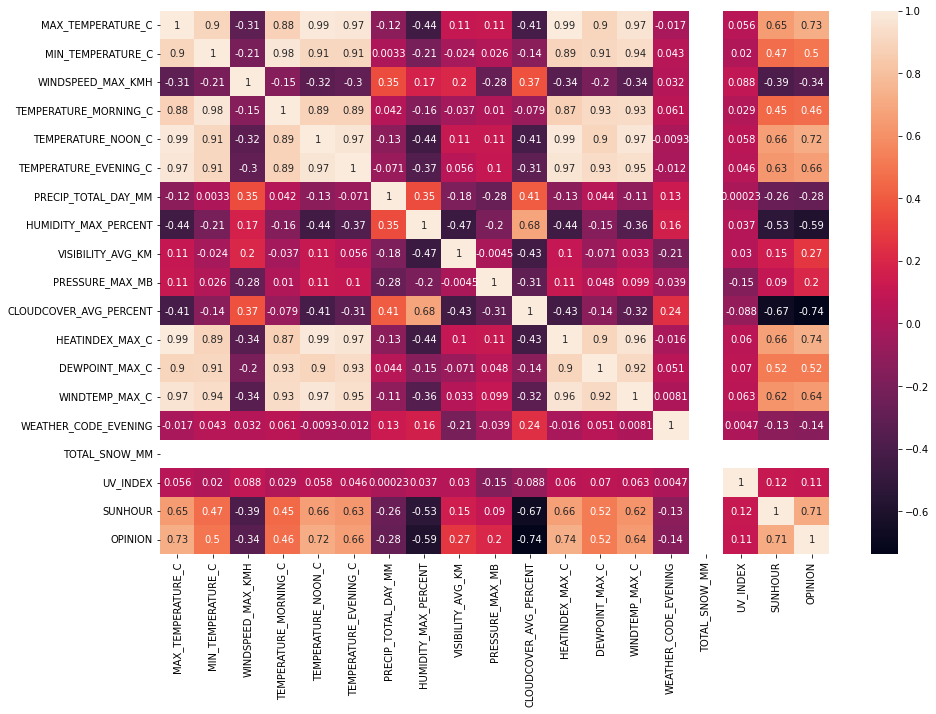

In [63]:
plt.figure(figsize=(15,10))
sns.heatmap(df_fact.corr(), annot = True)
plt.show()

On note donc une potentielle corrélation d'OPINION avec :      
- Max_temperature
- Min température
- Temperature morning, noon, evening
- humidity max percent
- cloudcover
- heatindex 
- dewpoint 
- windtemps 
- sunhour (que je ne garde pas car dans le df_nan ce sont des valeurs manquantes)

In [11]:
df2018_clean.columns

Index(['DATE', 'MAX_TEMPERATURE_C', 'MIN_TEMPERATURE_C', 'WINDSPEED_MAX_KMH',
       'TEMPERATURE_MORNING_C', 'TEMPERATURE_NOON_C', 'TEMPERATURE_EVENING_C',
       'PRECIP_TOTAL_DAY_MM', 'HUMIDITY_MAX_PERCENT', 'VISIBILITY_AVG_KM',
       'PRESSURE_MAX_MB', 'CLOUDCOVER_AVG_PERCENT', 'HEATINDEX_MAX_C',
       'DEWPOINT_MAX_C', 'WINDTEMP_MAX_C', 'WEATHER_CODE_EVENING',
       'TOTAL_SNOW_MM', 'UV_INDEX', 'SUNHOUR', 'OPINION'],
      dtype='object')

In [64]:
# X et y (avec toutes les colonnes numériques du DF)
y = df2018_clean['OPINION']
X = df2018_clean[['MAX_TEMPERATURE_C', 'MIN_TEMPERATURE_C', 'WINDSPEED_MAX_KMH',
       'TEMPERATURE_MORNING_C', 'TEMPERATURE_NOON_C', 'TEMPERATURE_EVENING_C',
       'PRECIP_TOTAL_DAY_MM', 'HUMIDITY_MAX_PERCENT', 'VISIBILITY_AVG_KM',
       'PRESSURE_MAX_MB', 'CLOUDCOVER_AVG_PERCENT', 'HEATINDEX_MAX_C',
       'DEWPOINT_MAX_C', 'WINDTEMP_MAX_C',]]

In [65]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42, train_size = 0.75)

In [59]:
df2018.isna().sum()

DATE                       0
MAX_TEMPERATURE_C          0
MIN_TEMPERATURE_C          0
WINDSPEED_MAX_KMH          0
TEMPERATURE_MORNING_C      0
TEMPERATURE_NOON_C         0
TEMPERATURE_EVENING_C      0
PRECIP_TOTAL_DAY_MM        0
HUMIDITY_MAX_PERCENT       0
VISIBILITY_AVG_KM          0
PRESSURE_MAX_MB            0
CLOUDCOVER_AVG_PERCENT     0
HEATINDEX_MAX_C            0
DEWPOINT_MAX_C             0
WINDTEMP_MAX_C             0
WEATHER_CODE_EVENING      24
TOTAL_SNOW_MM             24
UV_INDEX                  24
SUNHOUR                   24
OPINION                   24
dtype: int64

## 3. KNN

### 3.1 premier test avec toutes les colonnes numériques

In [66]:
# model 
modelKNN = KNeighborsClassifier()

# fit
modelKNN.fit(X_train, y_train)

# score :
print("Score for the Train dataset :", modelKNN.score(X_train, y_train))
print("Score for the Test dataset :", modelKNN.score(X_test, y_test))

Score for the Train dataset : 0.8
Score for the Test dataset : 0.7790697674418605


### 3.2 Test avec les colonnes corrélées 

In [67]:
y2 = df2018_clean['OPINION']
X2 = df2018_clean[['MAX_TEMPERATURE_C', 'MIN_TEMPERATURE_C',
       'TEMPERATURE_MORNING_C', 'TEMPERATURE_NOON_C', 'TEMPERATURE_EVENING_C',
        'HUMIDITY_MAX_PERCENT', 'CLOUDCOVER_AVG_PERCENT', 'HEATINDEX_MAX_C',
       'DEWPOINT_MAX_C', 'WINDTEMP_MAX_C']]

 # train test split
X2_train, X2_test, y2_train, y2_test = train_test_split(X2,y2, random_state = 42, train_size = 0.75)

In [68]:
modelKNN2 = KNeighborsClassifier()

# fit
modelKNN2.fit(X2_train, y2_train)

# score :
print("Score for the Train dataset :", modelKNN2.score(X2_train, y2_train))
print("Score for the Test dataset :", modelKNN2.score(X2_test, y2_test))

Score for the Train dataset : 0.8235294117647058
Score for the Test dataset : 0.813953488372093


C'est mieux, voyons avec des hyperparams modifiés

### 3.3 Changement des Hyperparams

In [69]:
# testons un nombre n de neighbors entre 1 et 10 et une alternance entre werights = distance et weights = uniform

for i in range(1,11):
  for j in ['uniform', 'distance']:
    model = KNeighborsClassifier(n_neighbors= i, weights= j)
    model.fit(X2_train, y2_train)
    print(f"Score for the Test dataset with {i} neighbors, and the {j} weight : {model.score(X2_test, y2_test)} ")
  print('\n')

Score for the Test dataset with 1 neighbors, and the uniform weight : 0.7906976744186046 
Score for the Test dataset with 1 neighbors, and the distance weight : 0.7906976744186046 


Score for the Test dataset with 2 neighbors, and the uniform weight : 0.7674418604651163 
Score for the Test dataset with 2 neighbors, and the distance weight : 0.7906976744186046 


Score for the Test dataset with 3 neighbors, and the uniform weight : 0.8372093023255814 
Score for the Test dataset with 3 neighbors, and the distance weight : 0.8255813953488372 


Score for the Test dataset with 4 neighbors, and the uniform weight : 0.7790697674418605 
Score for the Test dataset with 4 neighbors, and the distance weight : 0.8255813953488372 


Score for the Test dataset with 5 neighbors, and the uniform weight : 0.813953488372093 
Score for the Test dataset with 5 neighbors, and the distance weight : 0.8023255813953488 


Score for the Test dataset with 6 neighbors, and the uniform weight : 0.77906976744186

Le modèle le plus performant est donc n = 3 et weight = uniform

### 3.4 Test final : n = 3 et weight = uniform

In [70]:
modelKNN3 = KNeighborsClassifier(n_neighbors= 3, weights= 'uniform')

# fit
modelKNN3.fit(X2_train, y2_train)

# score :
print("Score for the Train dataset :", modelKNN3.score(X2_train, y2_train))
print("Score for the Test dataset :", modelKNN3.score(X2_test, y2_test))

Score for the Train dataset : 0.8666666666666667
Score for the Test dataset : 0.8372093023255814


## 4. Logistic Regression

### 4.1 avec toutes les données numériques du dataframe

In [71]:
# la colonne cible doit être numérique donc je repars de mon dataframe df_fact
y = df_fact['OPINION']
X = df_fact[['MAX_TEMPERATURE_C', 'MIN_TEMPERATURE_C', 'WINDSPEED_MAX_KMH',
       'TEMPERATURE_MORNING_C', 'TEMPERATURE_NOON_C', 'TEMPERATURE_EVENING_C',
       'PRECIP_TOTAL_DAY_MM', 'HUMIDITY_MAX_PERCENT', 'VISIBILITY_AVG_KM',
       'PRESSURE_MAX_MB', 'CLOUDCOVER_AVG_PERCENT', 'HEATINDEX_MAX_C',
       'DEWPOINT_MAX_C', 'WINDTEMP_MAX_C']]

# train test split
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42, train_size = 0.75)

# model 
modelLR = LogisticRegression().fit(X_train,y_train)

# score
print('Accuracy score on the train set :', modelLR.score(X_train, y_train))
print('Accuracy score on the test set :', modelLR.score(X_test, y_test))  
print("Nb of iterations : ", modelLR.n_iter_ )

Accuracy score on the train set : 0.807843137254902
Accuracy score on the test set : 0.7558139534883721
Nb of iterations :  [100]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### 4.2 avec les colonnes corrélées

In [72]:
y2 = df_fact['OPINION']
X2 = df_fact[['MAX_TEMPERATURE_C', 'MIN_TEMPERATURE_C',
       'TEMPERATURE_MORNING_C', 'TEMPERATURE_NOON_C', 'TEMPERATURE_EVENING_C',
        'HUMIDITY_MAX_PERCENT', 'CLOUDCOVER_AVG_PERCENT', 'HEATINDEX_MAX_C',
       'DEWPOINT_MAX_C', 'WINDTEMP_MAX_C']]

 # train test split
X2_train, X2_test, y2_train, y2_test = train_test_split(X2,y2, random_state = 42, train_size = 0.75)

In [73]:
modelLR2 = LogisticRegression()

# fit
modelLR2.fit(X2_train, y2_train)

# score :
print("Score for the Train dataset :", modelLR2.score(X2_train, y2_train))
print("Score for the Test dataset :", modelLR2.score(X2_test, y2_test))

Score for the Train dataset : 0.8313725490196079
Score for the Test dataset : 0.7558139534883721


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### 4.3 En standardisant les valeurs

In [74]:
modelLR_scale = make_pipeline(StandardScaler(), LogisticRegression())
modelLR_scale.fit(X2_train, y2_train)

print("Score for the Train dataset :", modelLR_scale.score(X2_train, y2_train))
print("Score for the Test dataset :", modelLR_scale.score(X2_test, y2_test))

Score for the Train dataset : 0.8431372549019608
Score for the Test dataset : 0.7906976744186046


### 4.4 en changeant le nombre d'itérations

In [75]:
modelLR3 = LogisticRegression(max_iter = 9000)
modelLR3.fit(X2_train, y2_train)

# score :
print("Score for the Train dataset :", modelLR3.score(X2_train, y2_train))
print("Score for the Test dataset :", modelLR3.score(X2_test, y2_test))


Score for the Train dataset : 0.8784313725490196
Score for the Test dataset : 0.7674418604651163


C'est long... trop long ! 

## 5. Decision Tree

### 5.1 Sur toutes les données numériques du DF

In [76]:
y = df_fact['OPINION']
X = df_fact[['MAX_TEMPERATURE_C', 'MIN_TEMPERATURE_C', 'WINDSPEED_MAX_KMH',
       'TEMPERATURE_MORNING_C', 'TEMPERATURE_NOON_C', 'TEMPERATURE_EVENING_C',
       'PRECIP_TOTAL_DAY_MM', 'HUMIDITY_MAX_PERCENT', 'VISIBILITY_AVG_KM',
       'PRESSURE_MAX_MB', 'CLOUDCOVER_AVG_PERCENT', 'HEATINDEX_MAX_C',
       'DEWPOINT_MAX_C', 'WINDTEMP_MAX_C']]

# train test split
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42, train_size = 0.75)
# model 
modelDT = DecisionTreeRegressor()

# fit
modelDT.fit(X_train, y_train)

# score :
print("Score for the Train dataset :", modelDT.score(X_train, y_train))
print("Score for the Test dataset :", modelDT.score(X_test, y_test))

Score for the Train dataset : 1.0
Score for the Test dataset : 0.959846857783173


### 5.2 Sur les valeurs corrélées

In [77]:
y2 = df_fact['OPINION']
X2 = df_fact[['MAX_TEMPERATURE_C', 'MIN_TEMPERATURE_C',
       'TEMPERATURE_MORNING_C', 'TEMPERATURE_NOON_C', 'TEMPERATURE_EVENING_C',
        'HUMIDITY_MAX_PERCENT', 'CLOUDCOVER_AVG_PERCENT', 'HEATINDEX_MAX_C',
       'DEWPOINT_MAX_C', 'WINDTEMP_MAX_C']]

 # train test split
X2_train, X2_test, y2_train, y2_test = train_test_split(X2,y2, random_state = 42, train_size = 0.75)

# model 
modelDT2 = DecisionTreeRegressor()
# fit
modelDT2.fit(X2_train, y2_train)

# score :
print("Score for the Train dataset :", modelDT2.score(X2_train, y2_train))
print("Score for the Test dataset :", modelDT2.score(X2_test, y2_test))

Score for the Train dataset : 1.0
Score for the Test dataset : 0.919693715566346


## 6. Utiliser le meilleur modèle sur df2018_nan pour prédire 'Opinion'

Le meilleur modèle est celui du decision Tree sur toutes les variables numériques. 



In [78]:
X_final = df2018_nan[['MAX_TEMPERATURE_C', 'MIN_TEMPERATURE_C',
       'TEMPERATURE_MORNING_C', 'TEMPERATURE_NOON_C', 'TEMPERATURE_EVENING_C',
        'HUMIDITY_MAX_PERCENT', 'CLOUDCOVER_AVG_PERCENT', 'HEATINDEX_MAX_C',
       'DEWPOINT_MAX_C', 'WINDTEMP_MAX_C']]

df2018_nan['OPINION'] = modelDT2.predict(X_final)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [79]:
df2018_nan.head()

,DATE,MAX_TEMPERATURE_C,MIN_TEMPERATURE_C,WINDSPEED_MAX_KMH,TEMPERATURE_MORNING_C,TEMPERATURE_NOON_C,TEMPERATURE_EVENING_C,PRECIP_TOTAL_DAY_MM,HUMIDITY_MAX_PERCENT,VISIBILITY_AVG_KM,PRESSURE_MAX_MB,CLOUDCOVER_AVG_PERCENT,HEATINDEX_MAX_C,DEWPOINT_MAX_C,WINDTEMP_MAX_C,WEATHER_CODE_EVENING,TOTAL_SNOW_MM,UV_INDEX,SUNHOUR,OPINION
18,2018-01-19,10,6,23,6,10,6,0.7,88,9.875,1020,37.000,10,6,5,NaN,NaN,NaN,NaN,0.0
31,2018-02-01,8,3,17,4,8,4,0.2,81,10.000,1012,39.500,8,3,2,NaN,NaN,NaN,NaN,1.0
66,2018-03-08,13,7,23,7,12,9,0.4,87,9.750,1005,52.625,13,7,6,NaN,NaN,NaN,NaN,0.0
100,2018-04-11,15,7,14,7,15,12,1.2,87,7.875,1002,59.125,15,10,10,NaN,NaN,NaN,NaN,2.0
118,2018-04-29,10,7,23,8,10,8,0.7,93,9.000,1008,85.000,10,9,7,NaN,NaN,NaN,NaN,0.0


In [98]:
# remettre les valeurs en lettre
# bad = 0, very bad = 1  , not good not bad = 3, good = 4 , very good = 2
def opinion(x):
  dico = {0 : 'bad', 1 : 'very bad', 3 : 'not good not bad', 4: 'good', 2: 'very good'}
  return dico[x]

df2018_nan['OPINION 2'] = df2018_nan['OPINION'].apply(opinion)

df2018_nan.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,DATE,MAX_TEMPERATURE_C,MIN_TEMPERATURE_C,WINDSPEED_MAX_KMH,TEMPERATURE_MORNING_C,TEMPERATURE_NOON_C,TEMPERATURE_EVENING_C,PRECIP_TOTAL_DAY_MM,HUMIDITY_MAX_PERCENT,VISIBILITY_AVG_KM,PRESSURE_MAX_MB,CLOUDCOVER_AVG_PERCENT,HEATINDEX_MAX_C,DEWPOINT_MAX_C,WINDTEMP_MAX_C,WEATHER_CODE_EVENING,TOTAL_SNOW_MM,UV_INDEX,SUNHOUR,OPINION,OPINION 2
18,2018-01-19,10,6,23,6,10,6,0.7,88,9.875,1020,37.000,10,6,5,NaN,NaN,NaN,NaN,0.0,bad
31,2018-02-01,8,3,17,4,8,4,0.2,81,10.000,1012,39.500,8,3,2,NaN,NaN,NaN,NaN,1.0,very bad
66,2018-03-08,13,7,23,7,12,9,0.4,87,9.750,1005,52.625,13,7,6,NaN,NaN,NaN,NaN,0.0,bad
100,2018-04-11,15,7,14,7,15,12,1.2,87,7.875,1002,59.125,15,10,10,NaN,NaN,NaN,NaN,2.0,very good
118,2018-04-29,10,7,23,8,10,8,0.7,93,9.000,1008,85.000,10,9,7,NaN,NaN,NaN,NaN,0.0,bad
